In [6]:
import pandas as pd  
import numpy as np
from pandas_datareader import data, wb
import datetime
import scipy.optimize as sco
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
tickers = ['BBRI.JK', 'BBCA.JK', 'ICBP.JK', 'SIDO.JK', 'ULTJ.JK']
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2020, 1, 1)
df = pd.DataFrame([data.DataReader(ticker, 'yahoo', start, end)['Adj Close'] for ticker in tickers]).T
df.columns = tickers

df.head()

,BBRI.JK,BBCA.JK,ICBP.JK,SIDO.JK,ULTJ.JK
Date,,,,,
2015-01-02,1349.378296,12170.641602,5705.682617,462.611877,909.677917
2015-01-05,1343.587036,12147.634766,5705.682617,462.611877,906.009827
2015-01-06,1334.900146,12055.606445,5575.516113,458.819946,929.240845
2015-01-07,1363.856812,12078.613281,5640.599609,470.195679,935.354309
2015-01-08,1387.022095,11940.572266,5640.599609,462.611877,1020.942261


### Function

In [11]:
def calc_portfolio_perf(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return portfolio_return, portfolio_std, sharpe_ratio

def simulate_random_portfolios(num_portfolios, mean_returns, cov, rf):
    results_matrix = np.zeros((len(mean_returns)+3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, sharpe_ratio = calc_portfolio_perf(weights, mean_returns, cov, rf)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = sharpe_ratio
        #iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j+3,i] = weights[j]
            
    results_df = pd.DataFrame(results_matrix.T,columns=['ret','stdev','sharpe'] + [ticker for ticker in tickers])
        
    return results_df

### Calculate Mean returns and covariance matrix

In [12]:
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()
num_portfolios = 100000
rf = 0.0
results_frame = simulate_random_portfolios(num_portfolios, mean_returns, cov, rf)

### Visualize the simulated portfolio

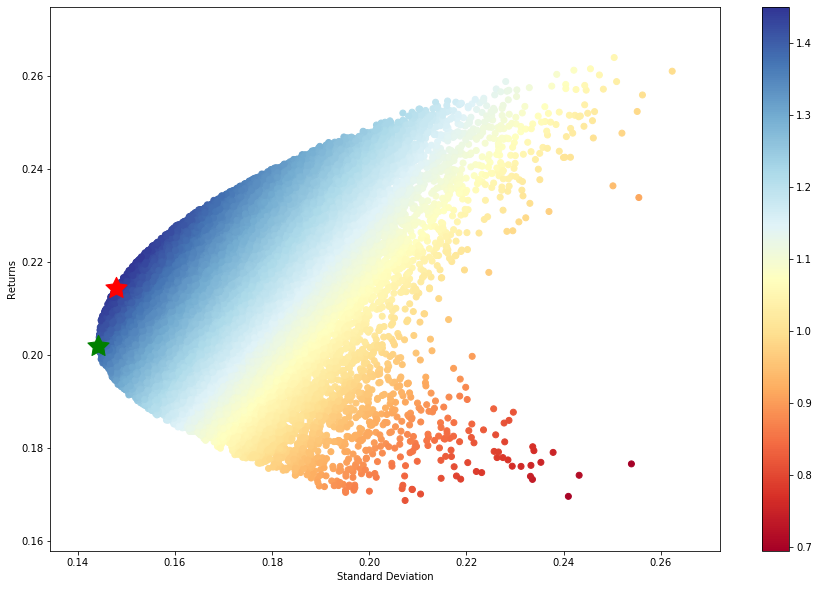

In [13]:
#locate position of portfolio with highest Sharpe Ratio
max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]

#locate positon of portfolio with minimum standard deviation
min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]

#create scatter plot coloured by Sharpe Ratio
plt.subplots(figsize=(15,10))
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()

#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=500)

#plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='g',s=500)
plt.show()

### Maximum Sharpe Portfolio

In [14]:
max_sharpe_port.to_frame().T

,ret,stdev,sharpe,BBRI.JK,BBCA.JK,ICBP.JK,SIDO.JK,ULTJ.JK
43343,0.214464,0.147934,1.449729,0.104243,0.404244,0.074587,0.219384,0.197542


### Minimum Sharpe Portfolio

In [15]:
min_vol_port.to_frame().T

,ret,stdev,sharpe,BBRI.JK,BBCA.JK,ICBP.JK,SIDO.JK,ULTJ.JK
58442,0.201878,0.144237,1.399628,0.007151,0.408355,0.159005,0.18855,0.236938


### Second approach to the optimisation using Scipy optimize function

### Maximum Variance Portfolio

In [16]:
def calc_neg_sharpe(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return -sharpe_ratio
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

def max_sharpe_ratio(mean_returns, cov, rf):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, rf)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_neg_sharpe, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result
optimal_port_sharpe = max_sharpe_ratio(mean_returns, cov, rf)

### Optimisation (Max)

In [17]:
pd.DataFrame([round(x,2) for x in optimal_port_sharpe['x']],index=tickers).T

,BBRI.JK,BBCA.JK,ICBP.JK,SIDO.JK,ULTJ.JK
0,0.11,0.4,0.07,0.23,0.18


### Minimum Variance Portfolio

In [18]:
def calc_portfolio_std(weights, mean_returns, cov):
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    return portfolio_std

def min_variance(mean_returns, cov):
    num_assets = len(mean_returns)
    args = (mean_returns, cov)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_std, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result
min_port_variance = min_variance(mean_returns, cov)

### Optimisation (Min)

In [19]:
pd.DataFrame([round(x,2) for x in min_port_variance['x']],index=tickers).T

,BBRI.JK,BBCA.JK,ICBP.JK,SIDO.JK,ULTJ.JK
0,0.01,0.41,0.16,0.19,0.23


### identifying the portfolio weights that minimise the Value at Risk (VaR).

In [20]:
def calc_portfolio_perf_VaR(weights, mean_returns, cov, alpha, days):
    portfolio_return = np.sum(mean_returns * weights) * days
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(days)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_return, portfolio_std, portfolio_var

def simulate_random_portfolios_VaR(num_portfolios, mean_returns, cov, alpha, days):
    results_matrix = np.zeros((len(mean_returns)+3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, portfolio_VaR = calc_portfolio_perf_VaR(weights, mean_returns, cov, alpha, days)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = portfolio_VaR
        #iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j+3,i] = weights[j]
            
    results_df = pd.DataFrame(results_matrix.T,columns=['ret','stdev','VaR'] + [ticker for ticker in tickers])
        
    return results_df

### Simulation Function and plot the result

In [22]:
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()
num_portfolios = 100000
rf = 0.0
days = 252
alpha = 0.05
results_frame = simulate_random_portfolios_VaR(num_portfolios, mean_returns, cov, alpha, days)

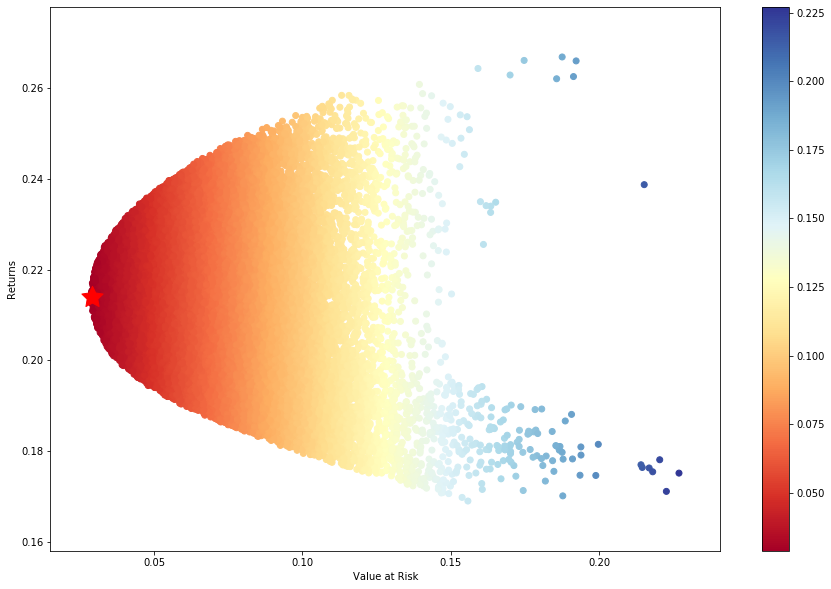

In [23]:
#locate positon of portfolio with minimum VaR
min_VaR_port = results_frame.iloc[results_frame['VaR'].idxmin()]

#create scatter plot coloured by VaR
plt.subplots(figsize=(15,10))
plt.scatter(results_frame.VaR,results_frame.ret,c=results_frame.VaR,cmap='RdYlBu')
plt.xlabel('Value at Risk')
plt.ylabel('Returns')
plt.colorbar()

#plot red star to highlight position of minimum VaR portfolio
plt.scatter(min_VaR_port[2],min_VaR_port[0],marker=(5,1,0),color='r',s=500)
plt.show()

### Weight of resulting Minimum VaR portofolio

In [24]:
min_VaR_port.to_frame().T

,ret,stdev,VaR,BBRI.JK,BBCA.JK,ICBP.JK,SIDO.JK,ULTJ.JK
12884,0.21396,0.147668,0.028933,0.094485,0.387366,0.09624,0.238232,0.183677


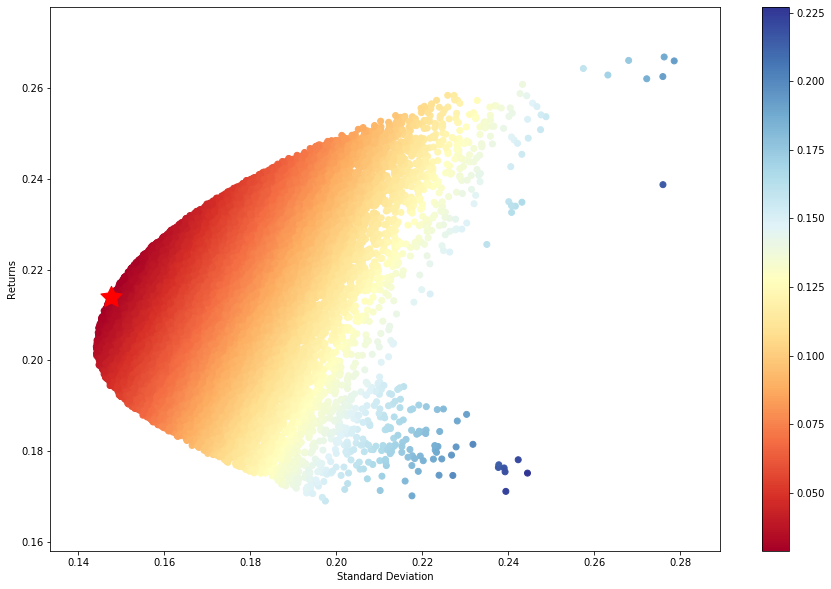

In [25]:
#locate positon of portfolio with minimum VaR
min_VaR_port = results_frame.iloc[results_frame['VaR'].idxmin()]

#create scatter plot coloured by VaR
plt.subplots(figsize=(15,10))
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.VaR,cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()

#plot red star to highlight position of minimum VaR portfolio
plt.scatter(min_VaR_port[1],min_VaR_port[0],marker=(5,1,0),color='r',s=500)
plt.show()

VaR falls when portfolio returns increase and vice versa, whereas the Sharpe ratio increases as portfolio returns increase – so what minimises VaR in terms of returns actually maximises the Sharpe ratio.

Similarly, an increase in portfolio standard deviation increases VaR but decreases the Sharpe ratio – so what maximises VaR in terms of portfolio standard deviation actually minimises the Sharpe ratio.

### identify the minimum VaR portfolio

In [26]:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

def calc_portfolio_VaR(weights, mean_returns, cov, alpha, days):
    portfolio_return = np.sum(mean_returns * weights) * days
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(days)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_var

def min_VaR(mean_returns, cov, alpha, days):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, alpha, days)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_VaR, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

min_port_VaR = min_VaR(mean_returns, cov, alpha, days)

In [27]:
pd.DataFrame([round(x,2) for x in min_port_VaR['x']],index=tickers).T

,BBRI.JK,BBCA.JK,ICBP.JK,SIDO.JK,ULTJ.JK
0,0.1,0.41,0.08,0.23,0.19


Ref : https://www.pythonforfinance.net/2019/07/02/investment-portfolio-optimisation-with-python-revisited/